<img style="float: right;" src="../images/logo-2pi-labs.png">

# Simple FMCW Radar Simulator

Author: Timo Jaeschke, 2pi-Labs GmbH \
Date: Jan 2023 \
License: Creative Commons [CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) (non-commercial)

### Python / Jupyter Notebook Implementation 
Import of necessary Python modules and settings:

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from dataclasses import dataclass
import collections
import scipy.constants as const

#params = {'legend.fontsize': 'x-large',
#          'figure.figsize': (14, 20),
#          'axes.labelsize': 'x-large',
#          'axes.titlesize':'x-large',
#          'xtick.labelsize':'x-large',
#          'ytick.labelsize':'x-large'}
#pylab.rcParams.update(params)

### Definition of FMCW Sensor, Processing Configuration & Target
Model a radar sensor and target based on the most relevant parameter:

In [3]:
## Simulation Model Definitions
# Define Radar, Target and Processing Model as a dataclass (Python >3.7)
@dataclass
class Radar_Model:
    name: str = 'Radar'           # Name string
    f_start: float = 126e9        # Start frequency in Hz
    f_stop: float = 182e9         # Stop frequency in Hz
    f_if: float = 5e6             # IF sampling frequency in Hz
    t_ramp: float = 1e-3          # Ramp duration in s
    
@dataclass
class Target_Model:
    name: str = 'Target'          # Name string
    distance: float = 0.5         # Target distance in m 
    velocity: float = 0           # Target velocity in m/s
    amplitude: float = 1          # Target amplitude
    reflection_phase: float = 0   # Target reflection phase in degree

@dataclass
class Processing_Config:
    name: str = 'ProcConf'        # Name string
    nfft: int = 2**16             # FFT points, IF data is zeropadded to this length       
    window: str = 'hann'          # Window function

Now, let's create a standard radar sensor with a processing configuration and two targets and print the configuration. 

In [4]:
Radar = Radar_Model('Radar0')
Targets = [
           Target_Model('Target0',0.5,0,1,0),       # Create a first target
           Target_Model('Target1',0.7,0,1,0)        # Create a second target
          ]
ProcConf = Processing_Config('ProcConf0')

In [5]:
print(f'Radar sensor configuration:')
print(f' Name:              {Radar.name}')
print(f' Start freq.:       {Radar.f_start/1e9} GHz')
print(f' Stop freq.:        {Radar.f_stop/1e9} GHz')
print(f' Bandwidth:         {(Radar.f_stop-Radar.f_start)/1e9} GHz')
print(f' IF sampling freq.: {Radar.f_if/1e6} MHz\n')

print(f'Processing configuration:')
print(f' Name:              {ProcConf.name}')
print(f' Nfft:              {ProcConf.nfft}\n')

print(f'Target configuration:')
for Target in Targets:
    print(f' {Target.name}: distance: {Target.distance}, velocity: {Target.velocity}, amplitude: {Target.amplitude}, reflection phase: {Target.reflection_phase}')

Radar sensor configuration:
 Name:              Radar0
 Start freq.:       126.0 GHz
 Stop freq.:        182.0 GHz
 Bandwidth:         56.0 GHz
 IF sampling freq.: 5.0 MHz

Processing configuration:
 Name:              ProcConf0
 Nfft:              65536

Target configuration:
 Target0: distance: 0.5, velocity: 0, amplitude: 1, reflection phase: 0
 Target1: distance: 0.7, velocity: 0, amplitude: 1, reflection phase: 0


## Axes Calculation for Fast-Time - Sweep & Range Domain

In [6]:
# Calculate Fast-Time Axes based on Radar and Processing Configuration 
def calcAxes(Radar_Model, Processing_Config):
    Axes = collections.namedtuple('Axes', 'ft_sweep_samples ft_sweep_time_axis ft_sweep_freq_axis ft_range_samples ft_range_freq_axis ft_range_dist_axis')
    sweep_points = np.round(Radar_Model.f_if * Radar_Model.t_ramp)
    span = Radar_Model.f_stop - Radar_Model.f_start
    
    # Fast Time Sweep-Domain Axis Calculation
    Axes.ft_sweep_samples = np.arange(0, sweep_points)
    Axes.ft_sweep_time_axis = Axes.ft_sweep_samples * Radar_Model.t_ramp / sweep_points
    Axes.ft_sweep_freq_axis = Radar_Model.f_start + Axes.ft_sweep_samples * span / sweep_points

    # Fast Time Range-Domain Axis Calculation
    Axes.ft_range_samples = np.arange(0, Processing_Config.nfft//2)
    Axes.ft_range_freq_axis = Axes.ft_range_samples * sweep_points / Radar_Model.t_ramp / Processing_Config.nfft               
    Axes.ft_range_time_axis = Axes.ft_range_samples * sweep_points / np.abs(span) / Processing_Config.nfft                         # Roundtrip delay
    Axes.ft_range_dist_axis = Axes.ft_range_samples * sweep_points / np.abs(span) / 2 * const.c / Processing_Config.nfft           # Distance (freespace)
    return Axes

In [7]:
# Test of Axes Generation 
Axes = calcAxes(Radar, ProcConf)
print ('Sweep-Axes') 
print ('  Samples: {Axes.ft_sweep_samples}') 
print ('  Time:',Axes.ft_sweep_time_axis) 
print ('  Frequency:',Axes.ft_sweep_freq_axis,'\n') 
print ('Range-Axes') 
print ('  Samples:',Axes.ft_range_samples) 
print ('  Frequency:',Axes.ft_range_freq_axis) 
print ('  Distance:',Axes.ft_range_dist_axis) 

Sweep-Axes
  Samples: {Axes.ft_sweep_samples}
  Time: [0.000e+00 2.000e-07 4.000e-07 ... 9.994e-04 9.996e-04 9.998e-04]
  Frequency: [1.260000e+11 1.260112e+11 1.260224e+11 ... 1.819664e+11 1.819776e+11
 1.819888e+11] 

Range-Axes
  Samples: [    0     1     2 ... 32765 32766 32767]
  Frequency: [0.00000000e+00 7.62939453e+01 1.52587891e+02 ... 2.49977112e+06
 2.49984741e+06 2.49992371e+06]
  Distance: [0.00000000e+00 2.04217405e-04 4.08434811e-04 ... 6.69118329e+00
 6.69138750e+00 6.69159172e+00]


## IF Signal Calculation

In [8]:
# Calculate IF/Beat Signal based on Radar and Taget data and Axes 
def calcIF(Radar, Target, Axes):
    sweep_points = int(np.round(Radar.f_if * Radar.t_ramp))
    span = Radar.f_stop - Radar.f_start
    
    IF = np.zeros(sweep_points)
    for Target in Targets:
        TargetDistance = np.ones(sweep_points) * Target.distance + Axes.ft_sweep_time_axis * Target.velocity
        #print(TargetDistance)
        # Calculate Time-Delay (Tau) over Time for Target
        TimeDelay = 2 * TargetDistance / const.c  # Tau - Time Delay
        # Calculate resulting IF 
        Ampl = Target.amplitude
        TermA = 2 * np.pi * span / Radar.t_ramp * TimeDelay * Axes.ft_sweep_time_axis
        TermB = 2 * np.pi * Radar.f_start * TimeDelay
        TermC = np.pi * span / Radar.t_ramp * TimeDelay**2
        TermD = Target.reflection_phase/360*2*np.pi
        #PN=Environment.Sim.EnablePN *gen_pn(size(Ampl,2),Sensor.ADC.fs,Sensor.Sim.PN_Level,Sensor.Sim.PN_FlickerCorner,Sensor.Sim.PN_Loopbandwidth); %Phase noise
        #IF = Ampl.*cos(TermA+TermB-TermC-TermD+PN)+RXN
        IF = IF+Target.amplitude * np.cos(TermA+TermB-TermC-TermD)
    #RXN=Environment.Sim.EnableRXN * Sensor.Sim.RXN_Level*randn(size(Ampl,2),1)'; % Receiver Noise
    return IF

In [9]:
def calcRP(if_signal, ProcConf):
    if_signal_spectrum = np.fft.ifft(if_signal,ProcConf.nfft)*ProcConf.nfft/len(if_signal)
    if_signal_spectrum = if_signal_spectrum *2
    return if_signal_spectrum

interactive(children=(FloatSlider(value=0.5, description='Target0Dist', max=2.0, min=0.001, step=0.01), FloatS…

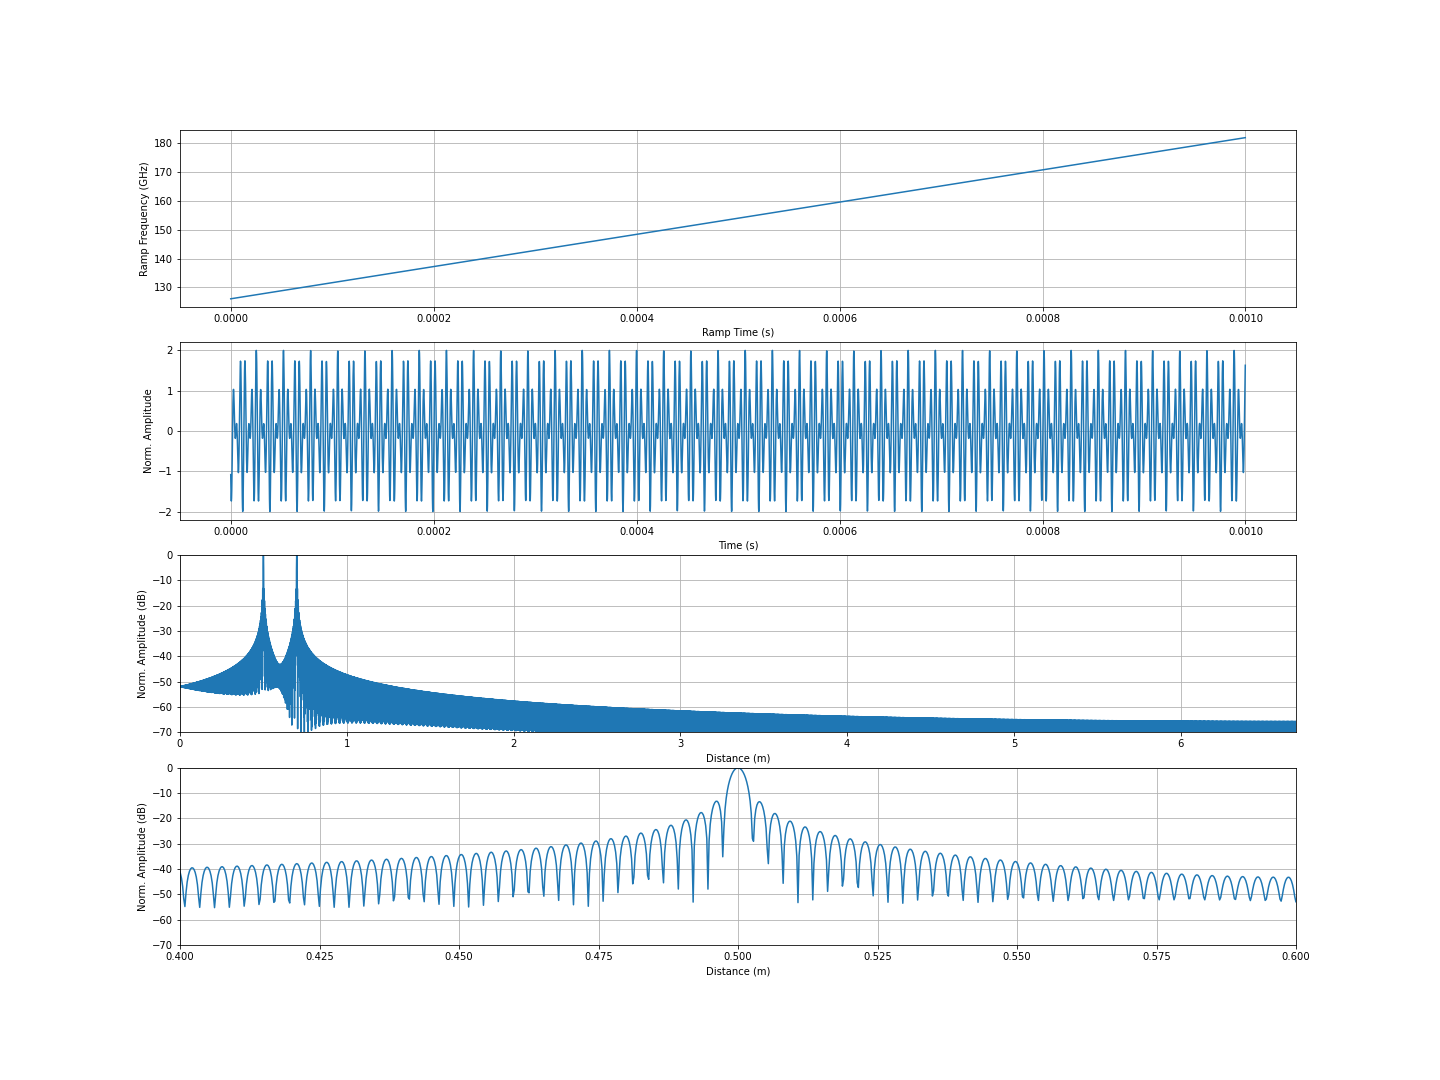

In [10]:
%matplotlib widget
import ipywidgets as interactive
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (20,15)
fig = plt.figure()
ax_frequency = fig.add_subplot(411)
ax_IF = fig.add_subplot(412)
ax_RangeProfile = fig.add_subplot(413)
ax_RangeProfile_zoom = fig.add_subplot(414)

ax_frequency.set_xlabel('Ramp Time (s)') 
ax_frequency.set_ylabel('Ramp Frequency (GHz)')
ax_frequency.grid()
ax_IF.set_xlabel('Time (s)') 
ax_IF.set_ylabel('Norm. Amplitude')
ax_IF.grid()
ax_RangeProfile.set_xlabel('Distance (m)') 
ax_RangeProfile.set_ylabel('Norm. Amplitude (dB)')
ax_RangeProfile.set_ylim([-70, 0])
ax_RangeProfile.grid()
ax_RangeProfile_zoom.set_xlabel('Distance (m)') 
ax_RangeProfile_zoom.set_ylabel('Norm. Amplitude (dB)')
ax_RangeProfile_zoom.set_ylim([-70, 0])
ax_RangeProfile_zoom.grid()


@interactive.interact(fStart=(116, 190, 0.1), fStop=(116, 190, 0.1), Target0Dist=(0.001, 2, 0.01), Target0Ampl=(0.001, 1, 0.01), Target1Dist=(0.001, 2, 0.01), Target1Ampl=(0.001, 1, 0.01))
def update(Target0Dist = Targets[0].distance,Target0Ampl = Targets[0].amplitude, Target1Dist = Targets[1].distance, Target1Ampl = Targets[1].amplitude, fStart = Radar.f_start/1e9, fStop = Radar.f_stop/1e9):
    [l.remove() for l in ax_frequency.lines];
    [l.remove() for l in ax_IF.lines];
    [l.remove() for l in ax_RangeProfile.lines];
    [l.remove() for l in ax_RangeProfile_zoom.lines];
    Targets[0].distance = Target0Dist;
    Targets[1].distance = Target1Dist;
    Targets[0].amplitude = Target0Ampl;
    Targets[1].amplitude = Target1Ampl;
    Radar.f_start = fStart*1e9;
    Radar.f_stop = fStop*1e9;
    
    Axes = calcAxes(Radar, ProcConf)
    IF = calcIF(Radar, Targets, Axes)
    RP = calcRP(IF, ProcConf)
    
    ax_RangeProfile.set_xlim([0, max(Axes.ft_range_dist_axis)])
    ax_RangeProfile_zoom.set_xlim([Target0Dist-0.1, Target0Dist+0.1])
    
    
    ax_frequency.plot(Axes.ft_sweep_time_axis, Axes.ft_sweep_freq_axis/1e9, color='C0')
    ax_IF.plot(Axes.ft_sweep_time_axis, IF, color='C0')
    ax_RangeProfile.plot(Axes.ft_range_dist_axis, 20*np.log10(np.abs(RP[:len(RP)//2])), color='C0')
    ax_RangeProfile_zoom.plot(Axes.ft_range_dist_axis, 20*np.log10(np.abs(RP[:len(RP)//2])), color='C0')
    
    